<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy-private/blob/main/examples/benchmarck_GPU_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarck GPU processing

In this notebook, a benchmark analysis is conducted to assess the processing time necessary for simulating signal propagation through the nonlinear fiber model, specifically employing the Manakov model. The propagation simulation is implemented numerically, utilizing a split-step Fourier (SSF) algorithm.

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

Cloning into 'OptiCommPy'...
remote: Enumerating objects: 10225, done.
remote: Counting objects: 100% (4273/4273), done.
remote: Compressing objects: 100% (941/941), done.
remote: Total 10225 (delta 3483), reused 4058 (delta 3313), pack-reused 5952
Receiving objects: 100% (10225/10225), 191.24 MiB | 29.92 MiB/s, done.
Resolving deltas: 100% (7603/7603), done.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.5/655.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 14.3 MB/s eta 0:00:00
  Created wheel for OptiCommPy: filename=OptiCommPy-0.7.0-py3-none-any.whl size=75621 sha256=63b6836fb77d8ea398046fb3af

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optic.models.modelsGPU import manakovSSF as manakovSSF_GPU
from optic.models.channels import manakovSSF as manakovSSF_CPU
from optic.dsp.coreGPU import firFilter as firFilter_GPU
from optic.dsp.core import firFilter as firFilter_CPU
from optic.dsp.core import pulseShape
from optic.models.tx import simpleWDMTx
from optic.utils import parameters

import logging as logg
logg.basicConfig(level=logg.WARN, format='%(message)s', force=True)

import time
from tqdm.notebook import tqdm

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

## Signal parameters

In [6]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 4            # samples per symbol
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 4096       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = -2       # power per WDM channel [dBm]
paramTx.Nch     = 1        # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3    # laser linewidth in Hz
paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]
paramTx.prgsBar = False    # show progress bar

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 500     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = False   # show progress bar
#paramCh.saveSpanN = [1, 5, 9, 14]
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate

## Compare CPU vs GPU processing

### manakovSSF

In [7]:
numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5])

timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

paramTx.Pch_dBm = -2 # power per WDM channel [dBm]

for idx, Nsymb in enumerate(tqdm(numberOfSymbols)):
    paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
    # generate WDM signal
    sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_CPU(sigWDM_Tx, paramCh)
    end = time.time()
    timeCPU[idx] = end - start

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_GPU(sigWDM_Tx, paramCh)
    end = time.time()
    timeGPU[idx] = end - start

  0%|          | 0/7 [00:00<?, ?it/s]

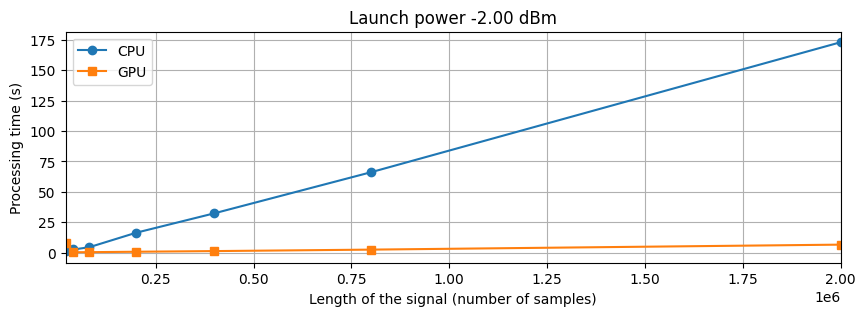

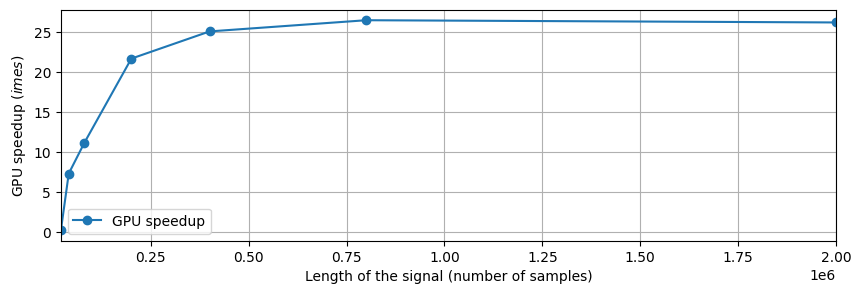

In [8]:
signalLength = numberOfSymbols*paramTx.SpS

plt.plot(signalLength, timeCPU,'-o', label='CPU')
plt.plot(signalLength, timeGPU,'-s', label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.title(f'Launch power {paramTx.Pch_dBm:.2f} dBm')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength))

plt.figure()
plt.plot(signalLength, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\times$)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

In [9]:
timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

paramTx.Pch_dBm = 4 # power per WDM channel [dBm]

for idx, Nsymb in enumerate(tqdm(numberOfSymbols)):
    paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
    # generate WDM signal
    sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_CPU(sigWDM_Tx, paramCh)
    end = time.time()
    timeCPU[idx] = end - start

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_GPU(sigWDM_Tx, paramCh)
    end = time.time()
    timeGPU[idx] = end - start

  0%|          | 0/7 [00:00<?, ?it/s]

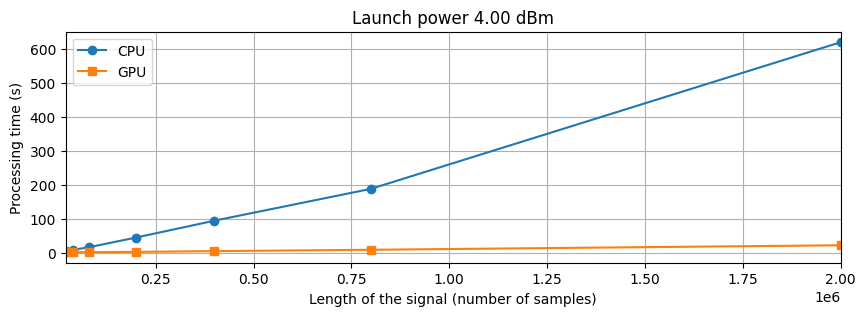

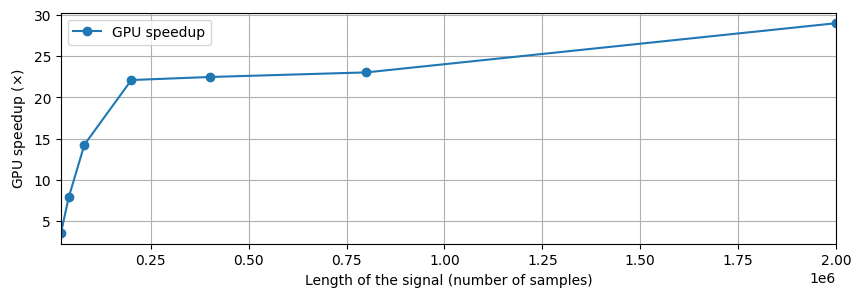

In [10]:
signalLength = numberOfSymbols*paramTx.SpS

plt.plot(signalLength, timeCPU,'-o', label='CPU')
plt.plot(signalLength, timeGPU,'-s', label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.title(f'Launch power {paramTx.Pch_dBm:.2f} dBm')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength))


plt.figure()
plt.plot(signalLength, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\\times$)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

### Compilation of results (length of the signal $>10^6$ samples)


| System configuration                     | GPU improvement  |
|:-----------------------------------|:------------------|
|Windows 64 bits Intel(R) Core(TM) i7-9700 CPU 3.00 GHz RAM 16.0 GB NVIDIA GeForce GTX 1060 6GB CUDA Version: 12.4| $\approx$ 17.5 - 20x|
|Google Colab System RAM 12.7 GB NVIDIA Tesla T4 15GB CUDA Version: 12.2| $\approx$  25x|

### firFilter

In [11]:
h = pulseShape('rrc')
numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5])

timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

nTrials = 20

for _ in tqdm(range(nTrials)):
    for idx, Nsymb in enumerate(numberOfSymbols):
        paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
        # generate WDM signal
        sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

        # fir filtering
        start = time.time()
        sigFilt = firFilter_CPU(h, sigWDM_Tx)
        end = time.time()
        timeCPU[idx] += end - start

        # fir filtering
        start = time.time()
        sigFilt = firFilter_GPU(h, sigWDM_Tx)
        end = time.time()
        timeGPU[idx] += end - start

timeGPU /= nTrials
timeCPU /= nTrials

  0%|          | 0/20 [00:00<?, ?it/s]

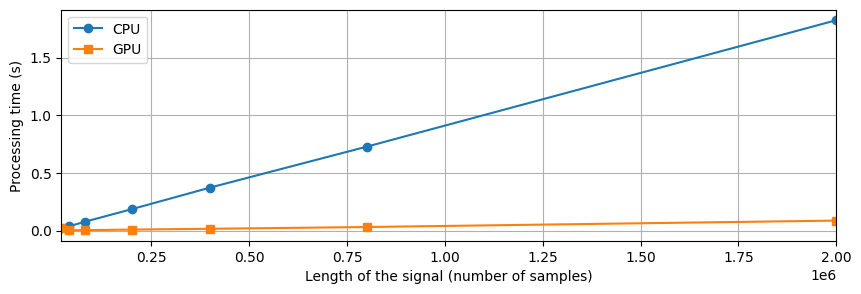

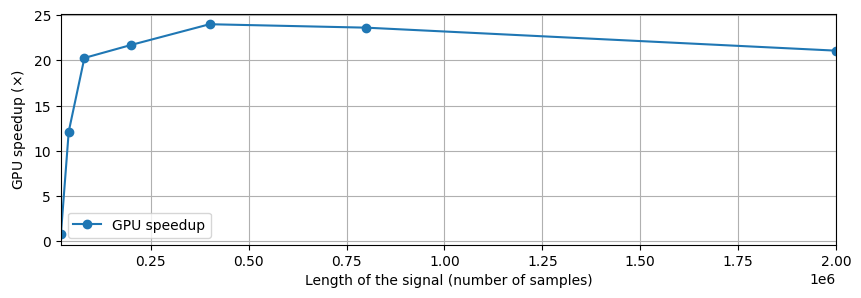

In [12]:
signalLength = numberOfSymbols*paramTx.SpS

plt.plot(signalLength, timeCPU,'-o', label='CPU')
plt.plot(signalLength, timeGPU,'-s', label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength))


plt.figure()
plt.plot(signalLength, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\\times$)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

### Compilation of results (length of the signal $>10^6$ samples)


| System configuration                     | GPU improvement  |
|:-----------------------------------|:------------------|
|Windows 64 bits Intel(R) Core(TM) i7-9700 CPU 3.00 GHz RAM 16.0 GB NVIDIA GeForce GTX 1060 6GB CUDA Version: 12.4| $\approx$ 16x|
|Google Colab System RAM 12.7 GB NVIDIA Tesla T4 15GB CUDA Version: 12.2| $\approx$ 20x|